In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

sys.path.append('../src')
import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

# DS Patient Matching Exploration

### EDA

In [83]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/ds_member_matching20221028.csv')
df.head()

df = df.loc[df.payer_id != 8]

In [27]:
df.describe()

,payer_id,patient_id,analytics_member_id,sfere_id,total_impairment_sum,adl_impairment_sum,transfer_bed_to_chair,transfer_chair_to_standing,mobility,dressing,bathing,eating,grooming,toileting,turn_change_position,calling_friends_and_family,articulating_needs,meal_prep,shopping,medication_management,finances,housework,transportation,driving,daily_routine_decisions,comprehension,member_opinion,cleaning,laundry,change_bed,clean_kitchen,clean_home,medical_appointments,work_school_socialize,reporting_current_hrs,reporting_rec_hrs,age
count,11009.000000,11009.000000,1.100900e+04,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11009.000000,11006.000000,11009.000000,363.000000,11009.000000,11009.000000,11009.000000,11009.000000,10868.000000,10651.000000,10087.000000,10646.000000,0.0,8584.000000,8584.000000,0.0,624.000000,1138.000000,363.000000,363.000000,363.000000,363.000000,363.000000,10677.000000,11009.000000,11009.000000
mean,4.990190,12297.745027,2.922960e+05,15913.728404,15.815696,9.720774,1.064039,1.093651,0.807975,1.667545,1.824871,0.453720,1.570325,1.222182,0.512397,0.175765,0.108638,1.121809,1.013080,0.671605,0.318280,1.388222,0.750047,NaN,0.168919,0.183481,NaN,1.464744,1.411248,1.479339,1.429752,1.438017,0.983471,0.848485,31.800019,26.126470,64.088746
std,2.433097,10275.187767,2.451486e+05,7650.974801,8.352120,7.030326,1.185159,1.194724,1.079761,1.084427,0.995281,0.906045,1.099794,1.235032,0.978631,0.417297,0.322664,0.699204,0.741112,0.729870,0.555386,0.664362,0.772829,NaN,0.395575,0.399525,NaN,0.662240,0.732183,0.706315,0.691221,0.692013,0.720460,0.748233,20.767535,16.628418,17.828561
min,1.000000,1.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,4.000000,4998.000000,2.508970e+05,9425.000000,10.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,19.000000,14.750000,55.000000
50%,5.000000,8945.000000,2.686460e+05,14535.000000,15.000000,9.000000,0.000000,1.000000,0.000000,2.000000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,27.750000,25.000000,65.000000
75%,6.000000,20900.000000,3.172410e+05,22806.000000,22.000000,14.000000,2.000000,2.000000,2.000000,2.000000,3.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,NaN,0.000000,0.000000,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,1.500000,1.000000,40.000000,35.000000,77.000000
max,12.000000,50508.000000,1.017208e+06,31902.000000,53.000000,27.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,2.000000,2.000000,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,168.000000,168.000000,105.000000


<AxesSubplot:xlabel='total_impairment_sum', ylabel='Count'>

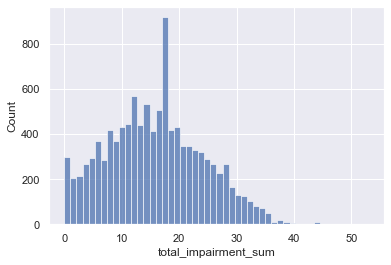

In [28]:
# histogram of total_impairment aka sum(iadl+adl)
sns.histplot(data=df, x="total_impairment_sum")

<AxesSubplot:xlabel='reporting_current_hrs', ylabel='Count'>

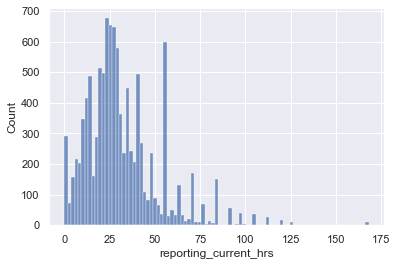

In [29]:
# histogram of current hrs
sns.histplot(data=df, x="reporting_current_hrs")

<AxesSubplot:xlabel='reporting_rec_hrs', ylabel='Count'>

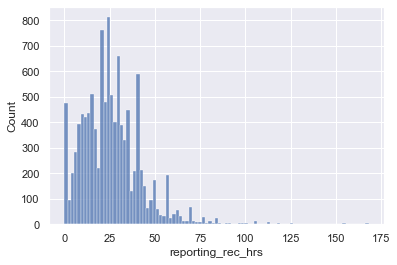

In [30]:
# histogram of recommended hrs
sns.histplot(data=df, x="reporting_rec_hrs")

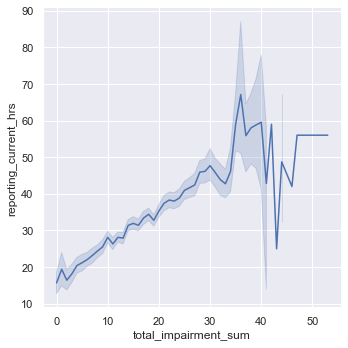

In [31]:
# total impairment vs current hrs
# highly reliable signal up to 30 impairment
sns.relplot(data=df, x='total_impairment_sum', y='reporting_current_hrs', kind='line')

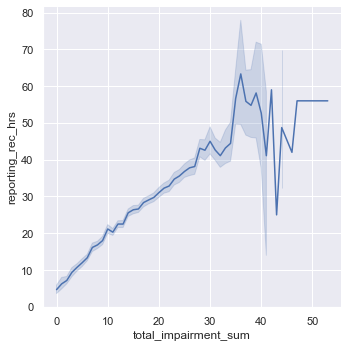

In [32]:
# total impairment vs rec hours
# slightly less variance than current (good)
# still only reliable to ~30
sns.relplot(data=df, x='total_impairment_sum', y='reporting_rec_hrs', kind='line')

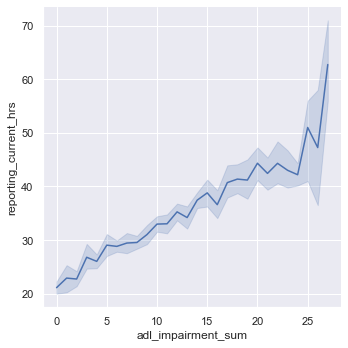

In [33]:
# just adl impairment vs current hrs
# similar pattern that stops at 25
# means adls may have most of the signal
sns.relplot(data=df, x='adl_impairment_sum', y='reporting_current_hrs', kind='line')

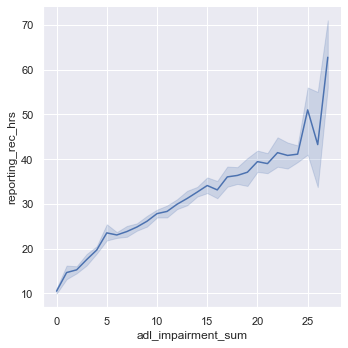

In [34]:
# adl vs rec hrs
# again similar pattern with less nose than current hours
sns.relplot(data=df, x='adl_impairment_sum', y='reporting_rec_hrs', kind='line')

### Signal

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

In [61]:
features = [
    'payer_id',
    'age',
    'reporting_current_hrs',
    # adls
    'transfer_bed_to_chair',
    'transfer_chair_to_standing',
    'mobility',
    'dressing',
    'bathing',
    'eating',
    'grooming',
    'toileting',
    'turn_change_position',
    # idls
    'calling_friends_and_family',
    'articulating_needs',
    'meal_prep',
    'shopping',
    'medication_management',
    'finances',
    'housework',
    'transportation',
    'driving',
    'daily_routine_decisions',
    'comprehension',
    'member_opinion',
    'cleaning',
    'laundry',
    'change_bed',
    'clean_kitchen',
    'clean_home',
    'medical_appointments',
    'work_school_socialize'
]
target = 'reporting_rec_hrs'

In [62]:
len(features)

31

In [63]:
# drop na targets from training set
training_df = df.loc[~df[target].isna()]
# training_df = df.loc[training_df[target] > 0]
X = training_df[features]
y = training_df[target]

In [64]:
X.shape[0]

11009

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
est = HistGradientBoostingRegressor().fit(X_train, y_train)
# est = HistGradientBoostingRegressor(categorical_features=[0]).fit(X_train, y_train)
preds = est.predict(X_test)
print('R2: ', est.score(X_test, y_test))

R2:  0.8227025348135655


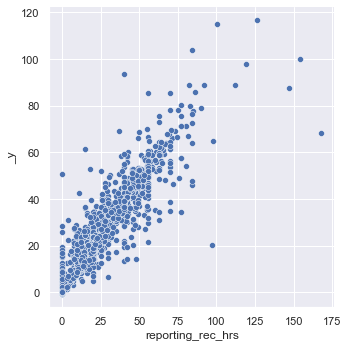

In [67]:
# preds vs rec
sns.relplot(x=y_test, y=preds)

In [68]:
# mean abs erorr
np.mean(np.abs(y_test - preds))

3.7702323059345395

### Add bounds with quantile regression
https://en.wikipedia.org/wiki/Quantile_regression

In [69]:
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

lower_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=LOWER_ALPHA).fit(X_train, y_train)
mid_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=.5).fit(X_train, y_train)
upper_model = HistGradientBoostingRegressor(categorical_features=[0], loss="quantile", quantile=UPPER_ALPHA).fit(X_train, y_train)

In [70]:
l_preds = lower_model.predict(X_test)
m_preds = mid_model.predict(X_test)
h_preds = upper_model.predict(X_test)
main_preds

In [79]:
vals = []
for i, p in enumerate(l_preds):
    vals.append([p, 'low', y_test.values[i]])
    
for i, m in enumerate(m_preds):
    vals.append([m, 'med', y_test.values[i]])
    
for i, h in enumerate(h_preds):
    vals.append([h, 'high', y_test.values[i]])
    
for i, h in enumerate(preds):
    vals.append([h, 'default', y_test.values[i]])
    
bounds_df = pd.DataFrame(vals, columns=['value', 'type', 'pred'])
bounds_df.head()
# bounds_df.assign( 

,value,type,pred
0,8.187464,low,13.0
1,13.029733,low,18.0
2,18.782597,low,23.0
3,21.762755,low,0.0
4,54.442487,low,83.0


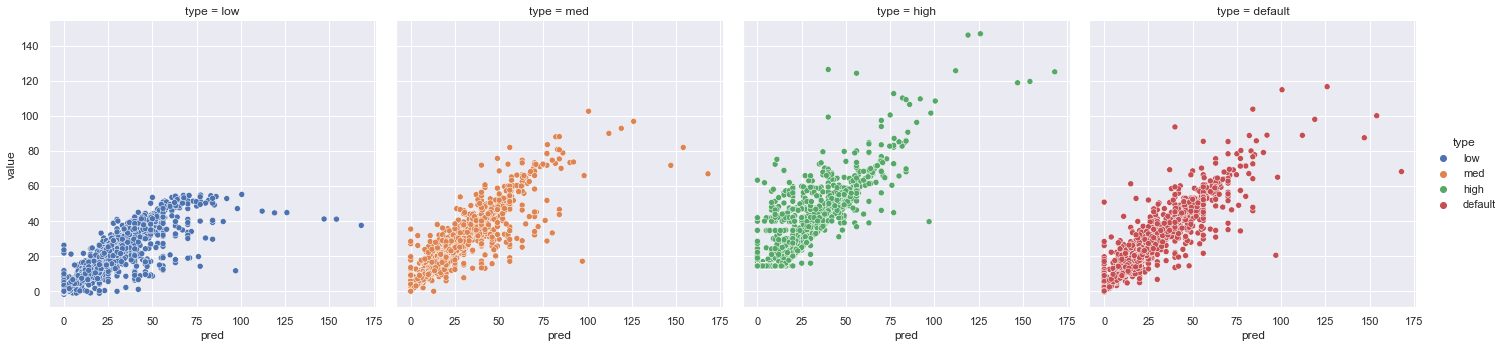

In [82]:
sns.relplot(data=bounds_df, x='pred', y='value', col='type', hue='type') 

### Nearest neighbors

In [ ]:
# need to fill na for knn
X = X.fillna(-1)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=20, p=2, metric='minkowski', n_jobs=-1).fit(X)

In [ ]:
distances, indices = nbrs.kneighbors(X)

In [ ]:
grp_stats = []
sample = 0
for sample in tqdm(range(training_df.shape[0] - 1)):
    neighbor_idxs = indices[sample]
    neighbors_df = training_df.iloc[neighbor_idxs]
    descr = neighbors_df.reporting_rec_hrs.describe()
    grp_stats.append(descr)

In [ ]:
stats = pd.DataFrame(grp_stats)

In [ ]:
stats.describe()

In [ ]:
# try classic KNN regr
neigh = KNeighborsRegressor(n_neighbors=20)

In [ ]:
neigh.fit(X, y)

In [ ]:
neigh.score(X, y)